In [1]:
import os, os.path
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from pathlib import Path
from torchvision import datasets, models, transforms

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

Module: Load_data

In [2]:
def load_data(hieroglyph_directory_path, batch_size=20, num_workers=0):
    train_dir = os.path.join(hieroglyph_directory_path, 'train/')
    test_dir = os.path.join(hieroglyph_directory_path, 'test/')

    classes = []

    for filename in os.listdir(train_dir):
        if filename == '.DS_Store':
            pass
        else:
            classes.append(filename)

    classes.sort()

    # print("Our classes:", classes)
    # print(len(classes))

    data_transform = transforms.Compose([transforms.ToTensor(),
                                            transforms.RandomApply([transforms.RandomHorizontalFlip()]),
                                            transforms.RandomRotation(degrees=(-10, 10)),
                                            transforms.RandomAffine(degrees=0, translate=(.1, .1)),
                                            transforms.RandomApply([transforms.ColorJitter(brightness=(1, 1.2),
                                                                                            contrast=(1, 1.5),
                                                                                            saturation=(1, 1.5),
                                                                                            hue=(0, 0.5))]),
                                            transforms.RandomErasing(p=0.5, scale=(0.05, 0.05), ratio=(0.3, 3.3), value=0,
                                                                      inplace=False),
                                            transforms.Resize((299, 299)),
                                            transforms.Normalize((0.5,), (0.5,))])

    train_data = datasets.ImageFolder(train_dir, transform=data_transform)
    test_data = datasets.ImageFolder(test_dir, transform=data_transform)


    # print('Num training images: ', len(train_data))
    # print('Num test images: ', len(test_data))

    # prepare data loaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                               num_workers=num_workers, shuffle=True, drop_last=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                              num_workers=num_workers, shuffle=True)

    return train_loader, test_loader, classes

Module: Train_model

In [3]:
def train_model(train_loader, optimizer, conv_net_model, criterion, my_lr_scheduler, n_epochs):
    # track training loss over time
    losses = []
    
    for epoch in range(1, n_epochs + 1):

        # keep track of training and validation loss
        train_loss = 0.0

        # model by default is set to train
        for batch_i, (data, target) in enumerate(train_loader):
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = conv_net_model(data)
            # calculate the batch loss
            loss = criterion(output.logits, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()

            my_lr_scheduler.step()

            if batch_i % 20 == 19:  # print training loss every specified number of mini-batches
                print('Epoch %d, Batch %d loss: %.16f' %
                    (epoch, batch_i + 1, train_loss / 20))
                losses.append(train_loss / 20)
                train_loss = 0.0

    return conv_net_model, losses

Module: Test_model

In [4]:
def test_model(classes, conv_net_model, test_loader, criterion):
    # track test loss
    test_loss = 0.0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))

    conv_net_model.eval()  # eval mode

    labels = []
    predictions = []
    # iterate over test data
    for data, target in test_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = conv_net_model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update  test loss
        test_loss += loss.item() * data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(len(target.data)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
        
        # Will be used for calculating Recall, Precision, and F1-score
        labels.extend(target.data.view_as(pred).tolist())
        predictions.extend(pred.tolist())


    # calculate avg test loss
    test_loss = test_loss / len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    return test_loss, class_correct, class_total, labels, predictions

Check whether CUDA is available (Change runtime type if not)

In [5]:
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


Load Hieroglyph Data

In [6]:
# Connecting and Mounting to the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
data_dir = '/content/drive/MyDrive/EgyptianHieroglyphDataset/'

In [8]:
hieroglyph_for_train = []
file_count_list = []

for name in os.listdir('/content/drive/MyDrive/EgyptianHieroglyphDataset/train/'):
  path, dirs, files = next(os.walk("/content/drive/MyDrive/EgyptianHieroglyphDataset/train/"+name))
  file_count = len(files)
  if file_count == 0:
    continue
  else:
    print(name, file_count)
    file_count_list.append(file_count)
    hieroglyph_for_train.append(name)

hieroglyph_dict = dict(zip(hieroglyph_for_train, file_count_list))

Aa15 2
Aa26 4
Aa27 2
Z1 39
Z11 8
Z7 3
Y2 5
Y3 2
Y5 6
E34 97
E1 5
E23 8
E9 8
W18 5
W24 31
W11 4
W22 1
W19 3
W25 9
D21 146
D4 29
D46 40
D1 4
D36 47
D58 28
D2 19
D35 45
D60 4
D28 13
D10 2
D39 1
D56 2
D19 2
D52 4
D54 9
D156 2
X1 185
X8 4
U15 10
U28 2
U1 20
U33 13
U7 3
T28 1
T22 7
T21 2
T20 3
T30 2
V31 106
V28 28
V13 63
V4 10
V30 6
V7 4
V24 4
V6 1
R8 53
R4 2
Q3 61
Q1 13
Q7 2
P8 12
P6 2
P98 4
P1 4
S29 212
S34 8
S24 1
S28 1
O50 84
O49 10
O28 8
O34 15
O1 16
O31 5
O4 11
I9 116
I10 32
G17 156
L1 2
M17 291
M44 5
M42 4
M1 2
M12 2
M18 10
M195 2
M20 2
M23 30
M41 2
M3 3
M16 1
M8 1
M40 2
M29 2
H6 5
N35 358
N5 16
N1 14
N37 24
N14 11
N31 13
N17 6
N29 14
N18 15
N41 2
N30 9
N25 1
N36 1
F13 6
F16 5
F35 2
F34 8
F31 6
F4 3
F40 1
F18 4
F9 2
F26 3
G39 16
G43 157
G5 24
G40 6
G7 8
G35 30
G1 28
G21 1
G25 21
G36 7
G4 6
G14 1
G26 1
G29 2
G37 2


Number of images for each hieroglyph 

<BarContainer object of 134 artists>

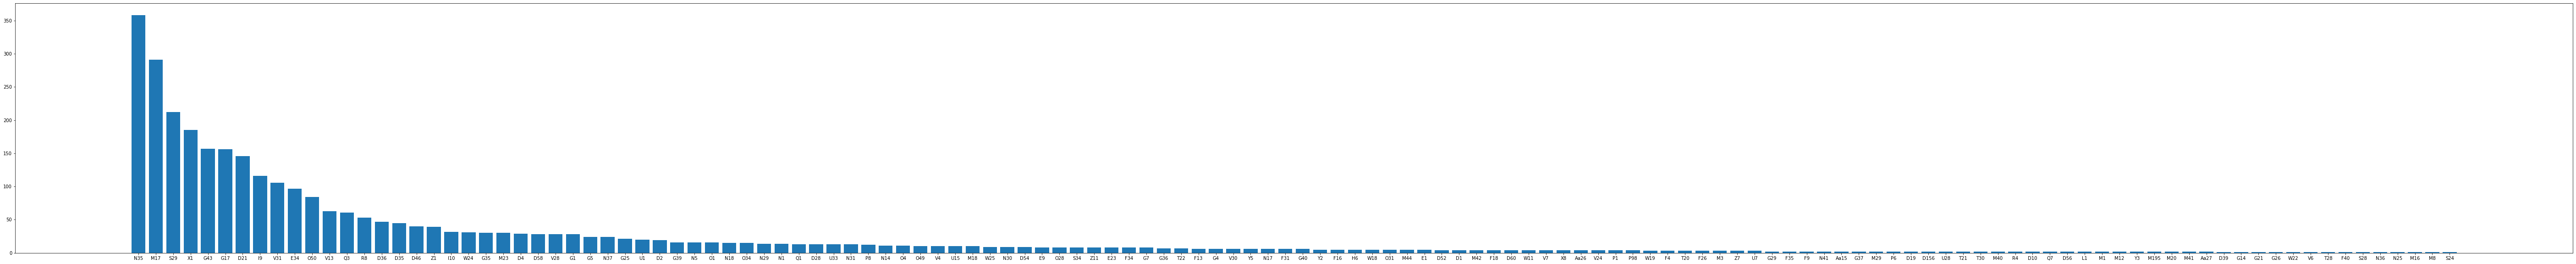

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({"Hieroglyph":hieroglyph_for_train, "Count":file_count_list})

df_sorted= df.sort_values('Count',ascending=False)

plt.figure(figsize=(100,10))
# make bar plot with matplotlib
plt.bar('Hieroglyph', 'Count',data=df_sorted)

In [10]:
print(len(hieroglyph_for_train))

134


In [11]:
print(hieroglyph_for_train)

['Aa15', 'Aa26', 'Aa27', 'Z1', 'Z11', 'Z7', 'Y2', 'Y3', 'Y5', 'E34', 'E1', 'E23', 'E9', 'W18', 'W24', 'W11', 'W22', 'W19', 'W25', 'D21', 'D4', 'D46', 'D1', 'D36', 'D58', 'D2', 'D35', 'D60', 'D28', 'D10', 'D39', 'D56', 'D19', 'D52', 'D54', 'D156', 'X1', 'X8', 'U15', 'U28', 'U1', 'U33', 'U7', 'T28', 'T22', 'T21', 'T20', 'T30', 'V31', 'V28', 'V13', 'V4', 'V30', 'V7', 'V24', 'V6', 'R8', 'R4', 'Q3', 'Q1', 'Q7', 'P8', 'P6', 'P98', 'P1', 'S29', 'S34', 'S24', 'S28', 'O50', 'O49', 'O28', 'O34', 'O1', 'O31', 'O4', 'I9', 'I10', 'G17', 'L1', 'M17', 'M44', 'M42', 'M1', 'M12', 'M18', 'M195', 'M20', 'M23', 'M41', 'M3', 'M16', 'M8', 'M40', 'M29', 'H6', 'N35', 'N5', 'N1', 'N37', 'N14', 'N31', 'N17', 'N29', 'N18', 'N41', 'N30', 'N25', 'N36', 'F13', 'F16', 'F35', 'F34', 'F31', 'F4', 'F40', 'F18', 'F9', 'F26', 'G39', 'G43', 'G5', 'G40', 'G7', 'G35', 'G1', 'G21', 'G25', 'G36', 'G4', 'G14', 'G26', 'G29', 'G37']


In [12]:
# Number of images processed in a single training
batch_size = 20
num_workers = 0

# The load_data function is from hieroglyph_data_preparation python file
train_loader, test_loader, classes = load_data(data_dir)

Inception-v3 Model

In [13]:
# Whether to extract features with the model
feature_extract = False
# Other selections
loss_function = "cross-entropy"
model_selection = "inception-v3"
optim_selection = "Adam"

# False if you want scratch model, True if you want pretrained model
whether_to_pretrain = True

# Load the model
if model_selection == "resnet-50":
    resnet50 = models.resnet50(pretrained=whether_to_pretrain)
    # Number of features in the last layer of resnet
    n_inputs = resnet50.fc.in_features
    # Add last linear layer (n_inputs -> 40 hieroglyph classes)
    last_layer = nn.Sequential(
                    nn.Linear(n_inputs, len(classes)))
    resnet50.fc = last_layer
    if train_on_gpu:
      resnet50.cuda()
    # Specify optimizer (Adam) and learning rate = 0.001
    if optim_selection == "Adam":
        optimizer = optim.Adam(resnet50.parameters(), lr=0.001)

elif model_selection == "inception-v3":
    inception_v3 = models.inception_v3(pretrained=whether_to_pretrain)
    # Number of features in the last layer of resnet
    n_inputs = inception_v3.fc.in_features
    # Add last linear layer (n_inputs -> 40 hieroglyph classes)
    last_layer = nn.Sequential(
                    nn.Linear(n_inputs, len(classes)))
    inception_v3.fc = last_layer
    if train_on_gpu:
      inception_v3.cuda()
    # Specify optimizer (Adam) and learning rate = 0.001
    if optim_selection == "Adam":
        optimizer = optim.Adam(inception_v3.parameters(), lr=0.001)


# Specify loss function (categorical cross-entropy)
if loss_function == "cross-entropy":
    criterion = nn.CrossEntropyLoss()

# Exponential Decay to strengthen learning
decayRate = 0.999
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

Training the model

In [14]:
# number of epochs to train the model
n_epochs = 50

if model_selection == "resnet-50":
  # The train_model function is from model_training python file
  resnet50, train_losses = train_model(train_loader, optimizer, resnet50, criterion, my_lr_scheduler, n_epochs)
elif model_selection == "inception-v3":
  # The train_model function is from model_training python file
  inception_v3, train_losses = train_model(train_loader, optimizer, inception_v3, criterion, my_lr_scheduler, n_epochs)

Epoch 1, Batch 20 loss: 3.5762116789817808
Epoch 1, Batch 40 loss: 3.2275458693504335
Epoch 1, Batch 60 loss: 2.7506455540657044
Epoch 1, Batch 80 loss: 2.5770955920219420
Epoch 1, Batch 100 loss: 2.1950903177261352
Epoch 1, Batch 120 loss: 2.1125891327857973
Epoch 1, Batch 140 loss: 2.0489808917045593
Epoch 2, Batch 20 loss: 1.7945414721965789
Epoch 2, Batch 40 loss: 1.7633963644504547
Epoch 2, Batch 60 loss: 1.5288139700889587
Epoch 2, Batch 80 loss: 1.7065683633089066
Epoch 2, Batch 100 loss: 1.2704366266727447
Epoch 2, Batch 120 loss: 1.3102701753377914
Epoch 2, Batch 140 loss: 1.2727173626422883
Epoch 3, Batch 20 loss: 1.1880132347345351
Epoch 3, Batch 40 loss: 1.1887400954961778
Epoch 3, Batch 60 loss: 1.1226800203323364
Epoch 3, Batch 80 loss: 1.0819807559251786
Epoch 3, Batch 100 loss: 0.9825193017721177
Epoch 3, Batch 120 loss: 0.9923608511686325
Epoch 3, Batch 140 loss: 1.0745205894112586
Epoch 4, Batch 20 loss: 0.8915896296501160
Epoch 4, Batch 40 loss: 0.7837303653359413
Ep

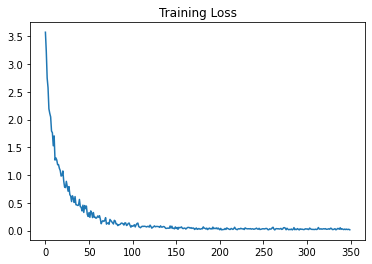

In [15]:
plt.plot(train_losses)
plt.title("Training Loss")
plt.show()

Testing the model

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [17]:
# The test_model function is from model_testing python file
test_loss, class_correct, class_total, labels, predictions = test_model(classes, inception_v3, test_loader, criterion)

# Test accuracy for each hieroglyph
for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (classes[i], 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

# Total Test accuracy
print("\nAccuracy: {:.3%}".format(accuracy_score(labels, predictions)))
print("\nPrecision: {:.3%}".format(precision_score(labels, predictions, average = 'weighted')))
print("\nRecall: {:.3%}".format(recall_score(labels, predictions, average = 'weighted')))
print("\nF1-score: {:.3%}".format(f1_score(labels, predictions, average = 'weighted')))

Test Loss: 0.298107

Test Accuracy of  Aa15: 100% ( 1/ 1)
Test Accuracy of  Aa26: 100% ( 1/ 1)
Test Accuracy of  Aa27: 100% ( 1/ 1)
Test Accuracy of    D1:  0% ( 0/ 1)
Test Accuracy of   D10:  0% ( 0/ 1)
Test Accuracy of  D156: 100% ( 1/ 1)
Test Accuracy of   D19: 100% ( 1/ 1)
Test Accuracy of    D2: 100% ( 5/ 5)
Test Accuracy of   D21: 97% (36/37)
Test Accuracy of   D28: 100% ( 4/ 4)
Test Accuracy of   D35: 100% (12/12)
Test Accuracy of   D36: 100% (12/12)
Test Accuracy of   D39:  0% ( 0/ 1)
Test Accuracy of    D4: 100% ( 8/ 8)
Test Accuracy of   D46: 100% (10/10)
Test Accuracy of   D52:  0% ( 0/ 1)
Test Accuracy of   D54: 100% ( 3/ 3)
Test Accuracy of   D56: 100% ( 1/ 1)
Test Accuracy of   D58: 100% ( 8/ 8)
Test Accuracy of   D60: 100% ( 2/ 2)
Test Accuracy of    E1: 100% ( 2/ 2)
Test Accuracy of   E23: 50% ( 1/ 2)
Test Accuracy of   E34: 100% (25/25)
Test Accuracy of    E9: 100% ( 2/ 2)
Test Accuracy of   F13: 100% ( 2/ 2)
Test Accuracy of   F16: 100% ( 2/ 2)
Test Accuracy of   F18:

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
